<a href="https://colab.research.google.com/github/Steriva/MfM_Assignment/blob/main/extra_NN_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of NN regression problem with PyTorch

This notebook implements a Neural Network (NN) to perform regression on a given parametric function $f(x,\mu)$.

In [ ]:
!apt-get update

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

### Loading packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg as splinalg
from scipy.sparse import spdiags
from scipy import sparse
from matplotlib import cm
from matplotlib import rcParams

from google.colab import files
import tqdm.notebook
# import tqdm.tqdm (uncomment this when executing as a .py)

from numpy import linalg
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = [r'\usepackage{amssymb,amsmath,amsthm, mathtools}']

The following parametric function will be
\begin{equation}
f(x;\,\mu) = (1-x)\cdot\cos(\mu^2\pi(1+x))\cdot e^{-\mu(1+x)}
\end{equation}

In [4]:
mu = np.array([1.2]) # np.linspace(0,3+1e-3,int(5e1))
x = np.zeros((int(1e3),))
x = np.linspace(-1,1+1e-3,int(1e2))
fun = lambda x, mu: (1-x) * np.cos(np.pi * (1+x) * mu**2) * np.exp(-mu * (1+x))

function_to_fit = np.zeros((1,len(x),1))
function_to_fit[0,:] = np.reshape(fun(x,mu[0]), [len(x),1])
x_input = np.block([[x],
                    [mu[0] * np.ones((len(x),))] ])

for ii in range(1, len(mu)):
  function_to_fit = np.block([function_to_fit, np.reshape(fun(x,mu[ii]), [len(x),1])])
  add_input = np.block([[x],
                       [mu[0] * np.ones((len(x),))] ])
  x_input = np.block([ x_input, add_input ])

function_to_fit = np.reshape(function_to_fit, (1,len(x_input.T)))

# train test split. Size of train data is 80% and size of test data is 20%. 
x_train, x_test, y_train, y_test = train_test_split(x_input.T, function_to_fit.T,
                                                    test_size = 0.2,
                                                    random_state = 42)

The data are now stored in *Tensor* data type

In [5]:
# create feature and targets tensor for train set, we need variable to accumulate gradients. 
# Therefore first we create tensor, then we will create variable
inputTrain  = torch.from_numpy(x_train.astype(np.float32))
outputTrain = torch.from_numpy(y_train.astype(np.float32))

inputTest  = torch.from_numpy(x_test.astype(np.float32))
outputTest = torch.from_numpy(y_test.astype(np.float32))

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(inputTrain,outputTrain)
test  = torch.utils.data.TensorDataset(inputTest, outputTest)

The batch size and the number of epochs is defined. Moreover, the data are stored in *data loader* type.

In [6]:
# batch_size, epoch and iteration
batch_size = 20
n_iters = 5000
num_epochs = n_iters / (len(inputTrain) / batch_size)
num_epochs = int(num_epochs)

# Data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, pin_memory = True, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test,  batch_size = batch_size, pin_memory = True, shuffle = True)

The neural network class is defined: three hidden layers are used activated with RELU.

In [7]:
class regressionNN(nn.Module):
  # Initialize the layers
  def __init__(self, input_dim, hidden_dim, output_dim):
      super(regressionNN, self).__init__()
      self.linear1 = nn.Linear(input_dim, hidden_dim)
      self.linear2 = nn.Linear(hidden_dim, hidden_dim)
      self.act = nn.ReLU() # Activation function
      self.linearOut = nn.Linear(hidden_dim, output_dim)
  
  # Perform the computation
  def forward(self, x):
      x = self.linear1(x)
      x = self.act(x)
      x = self.linear2(x)
      x = self.act(x)
      x = self.linearOut(x)
      return x

In [ ]:
input_dim = 2
output_dim = 1
hidden_dim = 200

model = regressionNN(input_dim, hidden_dim, output_dim)

learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate )

loss_stats = { 'train': [], "test": [] }

for epoch in tqdm.notebook.tqdm(range(1,num_epochs+1)):
  train_epoch_loss = 0

  for param, target in train_loader:

    # Clear gradients
    optimizer.zero_grad()
    
    # Forward propagation
    NN_predict = model(param)
    
    # Compute loss
    loss = loss_fn(NN_predict, target)
    
    # Calculating gradients
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    train_epoch_loss += loss.item()

  with torch.no_grad():
      test_epoch_loss = 0

      for param, target in test_loader:
        NN_predict = model(param)
        loss = loss_fn(NN_predict, target)
        test_epoch_loss += loss.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['test'].append(test_epoch_loss/len(test_loader)) 
  print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {test_epoch_loss/len(test_loader):.5f}')

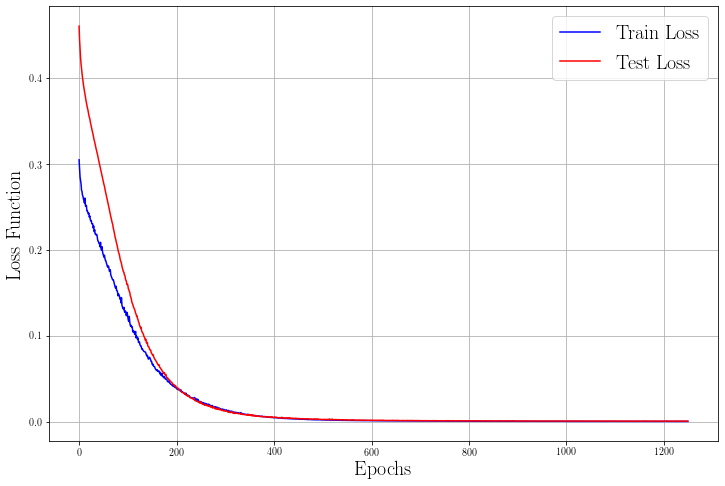

In [9]:
lossFtFigure = plt.figure()

plt.plot(loss_stats['train'], 'b', label = 'Train Loss')
plt.plot(loss_stats['test'],  'r', label = 'Test Loss')
plt.xlabel(r'Epochs', fontsize = 20)
plt.ylabel(r'Loss Function', fontsize = 20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize = 20)

lossFtFigure.savefig('lossFt.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [10]:
class regressionNN(nn.Module):
  # Initialize the layers
  def __init__(self, input_dim, hidden_dim, output_dim):
      super(regressionNN, self).__init__()
      self.linear1 = nn.Linear(input_dim, hidden_dim)
      self.act = nn.ReLU() # Activation function
      self.linearOut = nn.Linear(hidden_dim, output_dim)
  
  # Perform the computation
  def forward(self, x):
      x = self.linear1(x)
      x = self.act(x)
      x = self.linearOut(x)
      return x

input_dim = 2
output_dim = 1

def computeError(hidden_dim):
  model = regressionNN(input_dim, hidden_dim, output_dim)

  learning_rate = 0.005
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate )

  loss_stats = { 'train': [], "test": [] }

  for epoch in range(1,num_epochs+1):
    train_epoch_loss = 0

    for param, target in train_loader:

      # Clear gradients
      optimizer.zero_grad()
      
      # Forward propagation
      NN_predict = model(param)
      
      # Compute loss
      loss = loss_fn(NN_predict, target)
      
      # Calculating gradients
      loss.backward()
      
      # Update parameters
      optimizer.step()
      
      train_epoch_loss += loss.item()

    with torch.no_grad():
        test_epoch_loss = 0

        for param, target in test_loader:
          NN_predict = model(param)
          loss = loss_fn(NN_predict, target)
          test_epoch_loss += loss.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader)) 
    # print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {test_epoch_loss/len(test_loader):.5f}')
  
  # compute error
  errorNN = np.zeros((len(x),1))
  for kk in range(len(x)):
    errorNN[kk] = model(torch.from_numpy(np.block([x[kk].astype(np.float32), mu[0].astype(np.float32)]))).detach().numpy() - function_to_fit[0,kk]
  return errorNN

  0%|          | 0/9 [00:00<?, ?it/s]

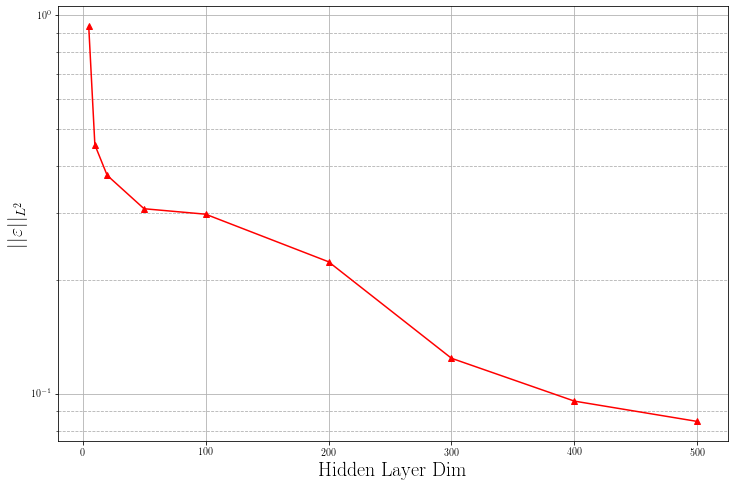

In [11]:
hidden_dimension = np.array([5, 10, 20, 50, 100, 200, 300, 400, 500])
errorMatrix = np.zeros((len(hidden_dimension),1))

for idx in tqdm.notebook.tqdm(range(len(hidden_dimension))):
  tmp = computeError(hidden_dimension[idx])
  errorMatrix[idx,0] = np.sqrt(np.trapz(np.power(tmp,2.), x, axis = 0) / np.trapz(np.power(function_to_fit[0,:],2.), x, axis = 0))

errorFigure = plt.figure()

plt.semilogy(hidden_dimension, errorMatrix, 'r-^')
plt.xlabel(r'Hidden Layer Dim', fontsize = 20)
plt.ylabel(r'$||\varepsilon||_{L^2}$', fontsize = 20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

errorFigure.savefig('error.pdf', format='pdf', dpi=600, bbox_inches='tight')